## ELEC4010N Assignment-01

Name:Lai Bo-Rong

Studen ID: 20737984

- Problem 1 (40%)

- Problem 2 (60%)

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# import packages
import torch
import numpy as np
from torch import nn
from torchvision import datasets, transforms
from tqdm import tqdm
import torch.optim as optim 
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [8]:
# load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=0.5,
        std=0.5
    )
])

data_train = datasets.MNIST(
    root="./data/",
    transform=transform,
    train=True,
    download=True
)

data_test = datasets.MNIST(
    root="./data/",
    transform=transform,
    train=False
)

loader_train = torch.utils.data.DataLoader(
    dataset=data_train,
    batch_size=64,
    shuffle=True
)

loader_test = torch.utils.data.DataLoader(
    dataset=data_test,
    batch_size=64,
    shuffle=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
# load EMNIST dataset
train_set = datasets.EMNIST(
    root="data", 
    split="balanced", 
    download="True",
    train=True, 
    transform=transform
)

test_set = datasets.EMNIST(
    root="data", 
    split="balanced", 
    download="True",
    train=False, 
    transform=transform

)
entire_trainset = torch.utils.data.DataLoader(train_set, shuffle=True)

split_train_size = int(0.8*(len(entire_trainset)))  # use 80% as train set
split_valid_size = len(entire_trainset) - split_train_size  # use 20% as validation set

train_set, val_set = torch.utils.data.random_split(
    train_set, [split_train_size, split_valid_size])

print(f'train set size: {split_train_size}, validation set size: {split_valid_size}')

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw
train set size: 90240, validation set size: 22560


### Problem 1. Train a four-layer MLP on MNIST dataset (40%)

Use a four-layer MLP to train the MNIST dataset. 

| Layer |  Type  |       Input       |      Output       | Activation |
| :---: | :----: | :---------------: | :---------------: | :--------: |
|   1   | Linear |      28 * 28      |         128         |    ReLU    |
|   2   | Linear |         128         |        64         |    ReLU    |
|   3   | Linear |        64         |        32         |    ReLU    |
|   4   | Linear |       32         |        10         |     -      |


a.) Implement the function `__init__` and `forward` in `Model` (15%);

b.) Implement the training code (15%).

c.) Plot the curve of accuracy and loss(10%).

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        ## ----- write your code here
        self.linear1 = nn.Linear(in_features=784, out_features=128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 32)
        self.linear4 = nn.Linear(32, 10)
        self.Relu = nn.ReLU(inplace=True)


    def forward(self, x):
        ## ----- write your code here        
        x = torch.flatten(x, start_dim=1, end_dim=3)
        x = self.linear1(x)
        self.Relu(x)
        x = self.linear2(x)
        self.Relu(x)
        x = self.linear3(x)
        self.Relu(x)
        x = self.linear4(x)        
      
        return x

In [7]:
max_epoch = 10
use_cuda = False

# model initialization
model = Model()
if use_cuda:
    model = model.cuda()

# loss function
criterion = nn.CrossEntropyLoss() ## ----- write your code here

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) ## ----- write your code here

loss_list = []
acc_train_list = []
acc_test_list = []
for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    # training
    model.train()
    for data in tqdm(loader_train):
        # set all gradients to zero
        optimizer.zero_grad()

        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        # model forward
        # print("this is images.shape: ", images.shape)
        # print("this is labels.shape: ", labels.shape)
        # print("this is labels: ", labels.dtype)
        outputs = model(images) ## ----- write your code here
        # print("this is outputs.shape: ", outputs.shape)
        # calculate loss
        loss = criterion(outputs, labels) ## ----- write your code here

        # backward and optimize parameters
        ## ----- write your code here
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        running_loss += loss.item()
        running_correct += torch.sum(pred == labels)
    
    # record loss, accuracy
    loss = running_loss / len(data_train)
    loss_list.append(loss)
    acc_train = running_correct / len(data_train)
    acc_train_list.append(acc_train.item())
    
    # testing
    model.eval()
    test_correct = 0
    for data in loader_test:
        # fetch data
        # model forward
        # record the correct
        ## ----- write your code here
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)
        pred = torch.argmax(outputs, dim=1)
        # print("This is pred.dtype", pred.dtype)
        # print("This is label.dtype", pred.dtype)
        for i in range(len(pred)):
          if(pred[i] == labels[i]):
            test_correct += 1
            
    acc_test = test_correct / len(data_test)
    acc_test_list.append(acc_test)
    print("Loss {:.4f}, Train Accuracy {:.4f}%, Test Accuracy {:.4f}%".format(
        loss,
        acc_train * 100,
        acc_test * 100
    ))

 -- Epoch 1/10


100%|██████████| 938/938 [00:17<00:00, 52.76it/s]


Loss 0.0083, Train Accuracy 83.1283%, Test Accuracy 92.9600%
 -- Epoch 2/10


100%|██████████| 938/938 [00:21<00:00, 44.34it/s]


Loss 0.0030, Train Accuracy 94.2017%, Test Accuracy 94.7200%
 -- Epoch 3/10


100%|██████████| 938/938 [00:18<00:00, 50.27it/s]


Loss 0.0022, Train Accuracy 95.6917%, Test Accuracy 95.6600%
 -- Epoch 4/10


100%|██████████| 938/938 [00:17<00:00, 53.12it/s]


Loss 0.0017, Train Accuracy 96.5517%, Test Accuracy 96.8200%
 -- Epoch 5/10


100%|██████████| 938/938 [00:18<00:00, 50.25it/s]


Loss 0.0015, Train Accuracy 97.0333%, Test Accuracy 96.8500%
 -- Epoch 6/10


100%|██████████| 938/938 [00:17<00:00, 54.07it/s]


Loss 0.0013, Train Accuracy 97.3600%, Test Accuracy 96.7200%
 -- Epoch 7/10


100%|██████████| 938/938 [00:18<00:00, 50.81it/s]


Loss 0.0011, Train Accuracy 97.7550%, Test Accuracy 96.5500%
 -- Epoch 8/10


100%|██████████| 938/938 [00:17<00:00, 53.38it/s]


Loss 0.0010, Train Accuracy 97.9600%, Test Accuracy 97.2400%
 -- Epoch 9/10


100%|██████████| 938/938 [00:18<00:00, 51.58it/s]


Loss 0.0009, Train Accuracy 98.1750%, Test Accuracy 97.6400%
 -- Epoch 10/10


100%|██████████| 938/938 [00:19<00:00, 48.35it/s]


Loss 0.0008, Train Accuracy 98.3333%, Test Accuracy 97.5600%


c.) Plot loss and accuracy curve

In the previous cell, you have recorded the loss and train/test accuracy in `loss_list`, `acc_train_list`, and `acc_test_list`, respectively. In this problem, you are required to plot two figures: 1.) training loss curve (5%); 2.) training and testing accuracy curves in the same figure (5%).

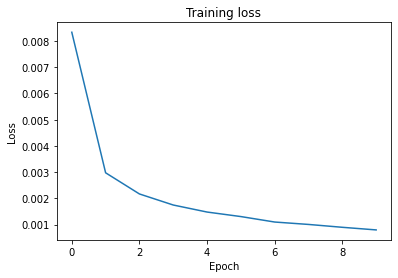

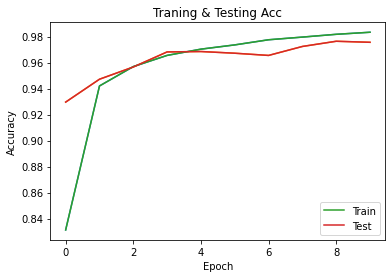

In [8]:
## ----- write your code here
plt.plot(loss_list)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.figure()
plt.plot(acc_train_list)
plt.plot(acc_test_list)
plt.title("Traning & Testing Acc")
plt.plot(acc_train_list, label="Train")
plt.plot(acc_test_list, label="Test")
plt.legend(loc="lower right")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Problem 2. Train a LeNet network on the EMINIST dataset (60%)

a.) Implement the model and training code (30%);

b.) Plot the loss and accuracy curves (10%);

c.) Try different batchsize, learning rate or optimizer, Any findings? Discuss the reason and possible solutions (20%);

In [10]:
## ----- write your code here.
class LeNet(nn.Module):

    # network structure
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        '''
        One forward pass through the network.
        
        Args:
            x: input
        '''
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) ## (28+2-5)/1 + 1 -> 26/2 -> 13
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2)) ## (13-5)/1 + 1 -> maxpool(9) == 5 
        x = x.view(-1, self.num_flat_features(x)) ## 64 x (16 channels * (5x5) pixels)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)

In [10]:
max_epoch = 10
use_cuda = False

# model initialization
model = LeNet()
if use_cuda:
    model = model.cuda()

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_list = []
acc_train_list = []
acc_test_list = []
for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    # training
    model.train()
    for data in tqdm(loader_train):
        # set all gradients to zero
        optimizer.zero_grad()

        # fetch data
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        # model forward  
        outputs = model(images)
        # calculate loss
        loss = criterion(outputs, labels)

        # backward and optimize parameters
      
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        running_loss += loss.item()
        running_correct += torch.sum(pred == labels)
    
    # record loss, accuracy
    loss = running_loss / len(data_train)
    loss_list.append(loss)
    acc_train = running_correct / len(data_train)
    acc_train_list.append(acc_train.item())
    
    # testing
    model.eval()
    test_correct = 0
    for data in loader_test:
        images, labels = data
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)
        pred = torch.argmax(outputs, dim=1)
        # print("This is pred.shape", pred.shape)
        # print("This is label.dtype", pred.dtype)
        test_correct += torch.sum(pred == labels)
            
    acc_test = test_correct / len(data_test)
    acc_test_list.append(acc_test.item())
    print("Loss {:.4f}, Train Accuracy {:.4f}%, Test Accuracy {:.4f}%".format(
        loss,
        acc_train * 100,
        acc_test * 100
    ))

 -- Epoch 1/10


100%|██████████| 938/938 [00:31<00:00, 29.94it/s]


Loss 0.0058, Train Accuracy 88.0217%, Test Accuracy 98.1200%
 -- Epoch 2/10


100%|██████████| 938/938 [00:30<00:00, 30.80it/s]


Loss 0.0010, Train Accuracy 98.0467%, Test Accuracy 98.2300%
 -- Epoch 3/10


100%|██████████| 938/938 [00:30<00:00, 31.00it/s]


Loss 0.0007, Train Accuracy 98.5133%, Test Accuracy 98.6100%
 -- Epoch 4/10


100%|██████████| 938/938 [00:30<00:00, 30.54it/s]


Loss 0.0006, Train Accuracy 98.9017%, Test Accuracy 98.6400%
 -- Epoch 5/10


100%|██████████| 938/938 [00:30<00:00, 30.87it/s]


Loss 0.0004, Train Accuracy 99.0917%, Test Accuracy 98.6800%
 -- Epoch 6/10


100%|██████████| 938/938 [00:31<00:00, 29.39it/s]


Loss 0.0004, Train Accuracy 99.2133%, Test Accuracy 98.8000%
 -- Epoch 7/10


100%|██████████| 938/938 [00:32<00:00, 28.86it/s]


Loss 0.0003, Train Accuracy 99.3117%, Test Accuracy 98.9200%
 -- Epoch 8/10


100%|██████████| 938/938 [00:30<00:00, 30.26it/s]


Loss 0.0003, Train Accuracy 99.4500%, Test Accuracy 98.9600%
 -- Epoch 9/10


100%|██████████| 938/938 [00:30<00:00, 30.44it/s]


Loss 0.0002, Train Accuracy 99.5400%, Test Accuracy 98.8900%
 -- Epoch 10/10


100%|██████████| 938/938 [00:31<00:00, 29.99it/s]


Loss 0.0002, Train Accuracy 99.5767%, Test Accuracy 98.8200%


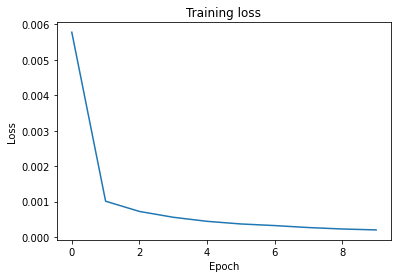

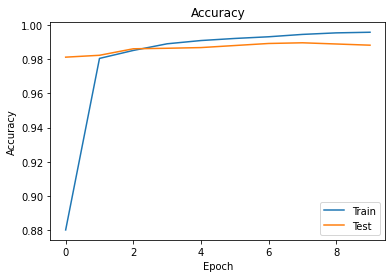

In [11]:
plt.plot(loss_list)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.figure()
plt.plot(acc_train_list, label="Train")
plt.plot(acc_test_list, label="Test")
plt.legend(loc="lower right")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [11]:
class OPT_CLASS():
  def __init__(self, opt_str, param, lr, momentum, decay):
    if(opt_str == "SGD"):
      self.opt = optim.SGD(param, lr=lr, momentum=momentum)
    elif(opt_str == "Adagrad"):
      self.opt = optim.Adagrad(param, lr=lr)
    elif(opt_str == "Adam"):
      self.opt = optim.Adam(param, lr=lr)
    elif(opt_str == "RMSprop"):
      self.opt = optim.RMSprop(param, lr=lr, momentum=momentum)
    
  def optim(self):
    return self.opt

In [18]:
max_epoch = 20
use_cuda = True

model = LeNet()
if use_cuda:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()

#define testing hyper-param
lr_list = [5e-2, 5e-4, 5e-7]
optim_list = ["SGD", "Adagrad", "Adam"]
batch_list = [64, 256]
avg_acc = 0
test_hist = {}
train_hist = {}
loss_hist = {}
best_acc = -999
best_hyper = {'Batchsize': 0, 'Learning Rate':0, 'Accuracy':0, 'Optimizer':''}

for opt_name in optim_list:
  for bsz in batch_list:
  ############################################################################################################################################
    # load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5,
            std=0.5
        )
    ])

    data_train = datasets.MNIST(
        root="./data/",
        transform=transform,
        train=True,
        download=True
    )

    data_test = datasets.MNIST(
        root="./data/",
        transform=transform,
        train=False
    )

    loader_train = torch.utils.data.DataLoader(
        dataset=data_train,
        batch_size=bsz,
        shuffle=True
    )

    loader_test = torch.utils.data.DataLoader(
        dataset=data_test,
        batch_size=bsz,
        shuffle=True
    )
    # load EMNIST dataset
    train_set = datasets.EMNIST(
        root="data", 
        split="balanced", 
        download="True",
        train=True, 
        transform=transform
    )

    test_set = datasets.EMNIST(
        root="data", 
        split="balanced", 
        download="True",
        train=False, 
        transform=transform

    )
    entire_trainset = torch.utils.data.DataLoader(train_set, shuffle=True)

    split_train_size = int(0.8*(len(entire_trainset)))  # use 80% as train set
    split_valid_size = len(entire_trainset) - split_train_size  # use 20% as validation set

    train_set, val_set = torch.utils.data.random_split(
        train_set, [split_train_size, split_valid_size])
  ########################################################################################################################
    for lr in lr_list:
      loss_list = []
      acc_train_list = []
      acc_test_list = []
      # reset model parameters
      for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()
      optim_obj = OPT_CLASS(opt_str=opt_name, param=model.parameters(), lr=lr, momentum=0.9, decay=1e-4)
      optimizer = optim_obj.optim()
      
      for epoch in range(max_epoch):
        running_loss = 0.0
        running_correct = 0
        print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

        # training
        model.train()
        for data in tqdm(loader_train):
            optimizer.zero_grad()
            images, labels = data
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
          
            loss.backward()
            optimizer.step()

            pred = torch.argmax(outputs, dim=1)
            running_loss += loss.item()
            running_correct += torch.sum(pred == labels)
        
        loss = running_loss / len(data_train)
        loss_list.append(loss)
        acc_train = running_correct / len(data_train)
        acc_train_list.append(acc_train.item())
        
        # testing
        model.eval()
        test_correct = 0
        for data in loader_test:
            images, labels = data
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            pred = torch.argmax(outputs, dim=1)
            test_correct += torch.sum(pred == labels)
                
        acc_test = test_correct / len(data_test)
        avg_acc += acc_test.item()
        acc_test_list.append(acc_test.item())
        if(epoch == (max_epoch-1)):
          test_hist[(lr, bsz, opt_name)] = acc_test_list
          train_hist[(lr, bsz, opt_name)] = acc_train_list
          loss_hist[(lr, bsz, opt_name)] = loss_list

        print("Loss {:.4f}, Train Accuracy {:.4f}%, Test Accuracy {:.4f}%, Batch Size {:.4f}, Learning Rate {:.7f}, Optimizer {optim}".format(
            loss,
            acc_train * 100,
            acc_test * 100,
            bsz,
            lr,
            optim=opt_name
        ))

      if((avg_acc/max_epoch) >= best_acc):
        best_acc = (avg_acc/max_epoch)
        best_hyper["Accuracy"] = best_acc * 100
        best_hyper["Batchsize"] = bsz
        best_hyper["Learning Rate"] = lr
        best_hyper["Optimizer"] = opt_name
      print("Current Acc: {:.4f}".format(avg_acc/max_epoch * 100))
      avg_acc = 0


print("---------------------------------")
print("Best combination: ", best_hyper)
print("---------------------------------")

 -- Epoch 1/20


100%|██████████| 938/938 [00:16<00:00, 57.07it/s]


Loss 0.0034, Train Accuracy 93.1550%, Test Accuracy 97.8100%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 2/20


100%|██████████| 938/938 [00:16<00:00, 56.16it/s]


Loss 0.0009, Train Accuracy 98.2717%, Test Accuracy 98.2800%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 3/20


100%|██████████| 938/938 [00:17<00:00, 54.62it/s]


Loss 0.0007, Train Accuracy 98.6433%, Test Accuracy 98.6300%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 4/20


100%|██████████| 938/938 [00:17<00:00, 52.82it/s]


Loss 0.0006, Train Accuracy 98.9150%, Test Accuracy 98.7500%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 5/20


100%|██████████| 938/938 [00:16<00:00, 57.63it/s]


Loss 0.0005, Train Accuracy 98.9733%, Test Accuracy 98.4000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 6/20


100%|██████████| 938/938 [00:16<00:00, 57.12it/s]


Loss 0.0005, Train Accuracy 99.1117%, Test Accuracy 98.7700%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 7/20


100%|██████████| 938/938 [00:16<00:00, 56.77it/s]


Loss 0.0004, Train Accuracy 99.2333%, Test Accuracy 98.1200%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 8/20


100%|██████████| 938/938 [00:16<00:00, 57.42it/s]


Loss 0.0004, Train Accuracy 99.3183%, Test Accuracy 98.8200%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 9/20


100%|██████████| 938/938 [00:16<00:00, 55.50it/s]


Loss 0.0004, Train Accuracy 99.3317%, Test Accuracy 98.7300%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 10/20


100%|██████████| 938/938 [00:16<00:00, 56.13it/s]


Loss 0.0002, Train Accuracy 99.5350%, Test Accuracy 98.9700%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 11/20


100%|██████████| 938/938 [00:16<00:00, 57.73it/s]


Loss 0.0003, Train Accuracy 99.4683%, Test Accuracy 98.4900%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 12/20


100%|██████████| 938/938 [00:16<00:00, 55.86it/s]


Loss 0.0003, Train Accuracy 99.4033%, Test Accuracy 98.7400%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 13/20


100%|██████████| 938/938 [00:16<00:00, 57.69it/s]


Loss 0.0002, Train Accuracy 99.5267%, Test Accuracy 98.7000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 14/20


100%|██████████| 938/938 [00:16<00:00, 55.80it/s]


Loss 0.0003, Train Accuracy 99.5117%, Test Accuracy 98.9000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 15/20


100%|██████████| 938/938 [00:16<00:00, 57.65it/s]


Loss 0.0003, Train Accuracy 99.5067%, Test Accuracy 98.0900%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 16/20


100%|██████████| 938/938 [00:17<00:00, 53.76it/s]


Loss 0.0004, Train Accuracy 99.3450%, Test Accuracy 98.8600%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 17/20


100%|██████████| 938/938 [00:17<00:00, 54.73it/s]


Loss 0.0002, Train Accuracy 99.5767%, Test Accuracy 99.0400%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 18/20


100%|██████████| 938/938 [00:16<00:00, 57.75it/s]


Loss 0.0003, Train Accuracy 99.5600%, Test Accuracy 98.8000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 19/20


100%|██████████| 938/938 [00:17<00:00, 55.03it/s]


Loss 0.0003, Train Accuracy 99.4917%, Test Accuracy 98.6200%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 20/20


100%|██████████| 938/938 [00:16<00:00, 56.65it/s]


Loss 0.0002, Train Accuracy 99.7083%, Test Accuracy 98.8200%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer SGD
Current Acc: 98.6170
 -- Epoch 1/20


100%|██████████| 938/938 [00:16<00:00, 56.00it/s]


Loss 0.0354, Train Accuracy 21.0700%, Test Accuracy 41.9800%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 2/20


100%|██████████| 938/938 [00:17<00:00, 54.56it/s]


Loss 0.0175, Train Accuracy 69.4733%, Test Accuracy 88.2000%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 3/20


100%|██████████| 938/938 [00:16<00:00, 57.00it/s]


Loss 0.0051, Train Accuracy 90.2867%, Test Accuracy 93.3100%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 4/20


100%|██████████| 938/938 [00:17<00:00, 53.93it/s]


Loss 0.0035, Train Accuracy 93.3967%, Test Accuracy 94.7500%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 5/20


100%|██████████| 938/938 [00:16<00:00, 57.81it/s]


Loss 0.0026, Train Accuracy 95.0067%, Test Accuracy 95.9400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 6/20


100%|██████████| 938/938 [00:16<00:00, 56.29it/s]


Loss 0.0021, Train Accuracy 95.8467%, Test Accuracy 96.4400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 7/20


100%|██████████| 938/938 [00:16<00:00, 58.17it/s]


Loss 0.0018, Train Accuracy 96.4167%, Test Accuracy 97.0000%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 8/20


100%|██████████| 938/938 [00:17<00:00, 52.92it/s]


Loss 0.0016, Train Accuracy 96.7533%, Test Accuracy 97.3700%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 9/20


100%|██████████| 938/938 [00:15<00:00, 58.63it/s]


Loss 0.0015, Train Accuracy 97.1117%, Test Accuracy 97.6200%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 10/20


100%|██████████| 938/938 [00:16<00:00, 57.25it/s]


Loss 0.0014, Train Accuracy 97.3000%, Test Accuracy 97.6200%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 11/20


100%|██████████| 938/938 [00:15<00:00, 58.89it/s]


Loss 0.0013, Train Accuracy 97.5667%, Test Accuracy 97.5700%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 12/20


100%|██████████| 938/938 [00:16<00:00, 58.47it/s]


Loss 0.0012, Train Accuracy 97.6850%, Test Accuracy 97.9000%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 13/20


100%|██████████| 938/938 [00:16<00:00, 56.22it/s]


Loss 0.0011, Train Accuracy 97.8067%, Test Accuracy 98.1400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 14/20


100%|██████████| 938/938 [00:15<00:00, 58.75it/s]


Loss 0.0011, Train Accuracy 97.9283%, Test Accuracy 98.0500%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 15/20


100%|██████████| 938/938 [00:17<00:00, 55.15it/s]


Loss 0.0010, Train Accuracy 98.0150%, Test Accuracy 98.3300%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 16/20


100%|██████████| 938/938 [00:16<00:00, 58.46it/s]


Loss 0.0009, Train Accuracy 98.1550%, Test Accuracy 98.3800%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 17/20


100%|██████████| 938/938 [00:16<00:00, 56.82it/s]


Loss 0.0009, Train Accuracy 98.2250%, Test Accuracy 98.2500%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 18/20


100%|██████████| 938/938 [00:16<00:00, 58.29it/s]


Loss 0.0009, Train Accuracy 98.2783%, Test Accuracy 98.4000%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 19/20


100%|██████████| 938/938 [00:15<00:00, 58.80it/s]


Loss 0.0008, Train Accuracy 98.4400%, Test Accuracy 98.4600%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 20/20


100%|██████████| 938/938 [00:16<00:00, 57.10it/s]


Loss 0.0008, Train Accuracy 98.4700%, Test Accuracy 98.4900%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer SGD
Current Acc: 94.1100
 -- Epoch 1/20


100%|██████████| 938/938 [00:17<00:00, 53.66it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 2/20


100%|██████████| 938/938 [00:16<00:00, 55.91it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 3/20


100%|██████████| 938/938 [00:16<00:00, 57.97it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 4/20


100%|██████████| 938/938 [00:16<00:00, 55.19it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 5/20


100%|██████████| 938/938 [00:16<00:00, 58.49it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 6/20


100%|██████████| 938/938 [00:16<00:00, 55.22it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 7/20


100%|██████████| 938/938 [00:15<00:00, 58.98it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 8/20


100%|██████████| 938/938 [00:16<00:00, 58.13it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 9/20


100%|██████████| 938/938 [00:16<00:00, 57.94it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 10/20


100%|██████████| 938/938 [00:16<00:00, 57.89it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 11/20


100%|██████████| 938/938 [00:16<00:00, 57.24it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 12/20


100%|██████████| 938/938 [00:16<00:00, 58.22it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 13/20


100%|██████████| 938/938 [00:17<00:00, 53.57it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 14/20


100%|██████████| 938/938 [00:16<00:00, 58.17it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 15/20


100%|██████████| 938/938 [00:16<00:00, 55.41it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 16/20


100%|██████████| 938/938 [00:16<00:00, 57.16it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 17/20


100%|██████████| 938/938 [00:16<00:00, 56.09it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 18/20


100%|██████████| 938/938 [00:16<00:00, 58.31it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 19/20


100%|██████████| 938/938 [00:16<00:00, 56.82it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 20/20


100%|██████████| 938/938 [00:16<00:00, 58.35it/s]


Loss 0.0360, Train Accuracy 9.7367%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer SGD
Current Acc: 9.8200
 -- Epoch 1/20


100%|██████████| 235/235 [00:14<00:00, 16.60it/s]


Loss 0.0025, Train Accuracy 78.7267%, Test Accuracy 97.8600%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 2/20


100%|██████████| 235/235 [00:14<00:00, 15.87it/s]


Loss 0.0002, Train Accuracy 98.0850%, Test Accuracy 98.6200%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 3/20


100%|██████████| 235/235 [00:14<00:00, 16.53it/s]


Loss 0.0002, Train Accuracy 98.6467%, Test Accuracy 98.8400%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 4/20


100%|██████████| 235/235 [00:14<00:00, 16.69it/s]


Loss 0.0001, Train Accuracy 98.9567%, Test Accuracy 98.6400%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 5/20


100%|██████████| 235/235 [00:14<00:00, 16.48it/s]


Loss 0.0001, Train Accuracy 99.1000%, Test Accuracy 98.8600%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 6/20


100%|██████████| 235/235 [00:14<00:00, 16.15it/s]


Loss 0.0001, Train Accuracy 99.2883%, Test Accuracy 99.0100%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 7/20


100%|██████████| 235/235 [00:14<00:00, 16.13it/s]


Loss 0.0001, Train Accuracy 99.3050%, Test Accuracy 99.1700%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 8/20


100%|██████████| 235/235 [00:14<00:00, 16.44it/s]


Loss 0.0001, Train Accuracy 99.4733%, Test Accuracy 99.1500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 9/20


100%|██████████| 235/235 [00:14<00:00, 15.91it/s]


Loss 0.0001, Train Accuracy 99.5550%, Test Accuracy 99.1600%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 10/20


100%|██████████| 235/235 [00:14<00:00, 16.57it/s]


Loss 0.0001, Train Accuracy 99.5583%, Test Accuracy 98.9100%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 11/20


100%|██████████| 235/235 [00:14<00:00, 16.63it/s]


Loss 0.0000, Train Accuracy 99.6667%, Test Accuracy 99.1000%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 12/20


100%|██████████| 235/235 [00:14<00:00, 16.71it/s]


Loss 0.0000, Train Accuracy 99.7300%, Test Accuracy 98.9300%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 13/20


100%|██████████| 235/235 [00:14<00:00, 16.11it/s]


Loss 0.0000, Train Accuracy 99.7683%, Test Accuracy 99.1200%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 14/20


100%|██████████| 235/235 [00:14<00:00, 16.60it/s]


Loss 0.0000, Train Accuracy 99.7817%, Test Accuracy 99.1500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 15/20


100%|██████████| 235/235 [00:13<00:00, 16.82it/s]


Loss 0.0000, Train Accuracy 99.8200%, Test Accuracy 99.0500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 16/20


100%|██████████| 235/235 [00:14<00:00, 16.49it/s]


Loss 0.0000, Train Accuracy 99.7867%, Test Accuracy 99.1400%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 17/20


100%|██████████| 235/235 [00:14<00:00, 16.62it/s]


Loss 0.0000, Train Accuracy 99.8933%, Test Accuracy 99.2000%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 18/20


100%|██████████| 235/235 [00:14<00:00, 16.61it/s]


Loss 0.0000, Train Accuracy 99.9217%, Test Accuracy 99.2500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 19/20


100%|██████████| 235/235 [00:13<00:00, 16.82it/s]


Loss 0.0000, Train Accuracy 99.9083%, Test Accuracy 99.0200%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
 -- Epoch 20/20


100%|██████████| 235/235 [00:15<00:00, 15.66it/s]


Loss 0.0000, Train Accuracy 99.7483%, Test Accuracy 99.0300%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer SGD
Current Acc: 98.9605
 -- Epoch 1/20


100%|██████████| 235/235 [00:14<00:00, 16.31it/s]


Loss 0.0090, Train Accuracy 9.7067%, Test Accuracy 10.6400%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 2/20


100%|██████████| 235/235 [00:14<00:00, 16.65it/s]


Loss 0.0090, Train Accuracy 13.2633%, Test Accuracy 20.7000%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 3/20


100%|██████████| 235/235 [00:14<00:00, 16.28it/s]


Loss 0.0089, Train Accuracy 31.5517%, Test Accuracy 36.4300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 4/20


100%|██████████| 235/235 [00:14<00:00, 16.69it/s]


Loss 0.0088, Train Accuracy 37.1950%, Test Accuracy 38.6100%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 5/20


100%|██████████| 235/235 [00:14<00:00, 16.38it/s]


Loss 0.0085, Train Accuracy 42.2933%, Test Accuracy 44.8600%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 6/20


100%|██████████| 235/235 [00:14<00:00, 16.57it/s]


Loss 0.0071, Train Accuracy 50.5450%, Test Accuracy 59.5400%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 7/20


100%|██████████| 235/235 [00:14<00:00, 15.88it/s]


Loss 0.0043, Train Accuracy 68.1567%, Test Accuracy 75.8100%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 8/20


100%|██████████| 235/235 [00:14<00:00, 16.69it/s]


Loss 0.0028, Train Accuracy 78.7017%, Test Accuracy 82.3800%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 9/20


100%|██████████| 235/235 [00:14<00:00, 16.44it/s]


Loss 0.0020, Train Accuracy 84.5117%, Test Accuracy 87.0300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 10/20


100%|██████████| 235/235 [00:14<00:00, 16.50it/s]


Loss 0.0016, Train Accuracy 88.1750%, Test Accuracy 89.5900%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 11/20


100%|██████████| 235/235 [00:14<00:00, 16.42it/s]


Loss 0.0013, Train Accuracy 90.3017%, Test Accuracy 91.3800%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 12/20


100%|██████████| 235/235 [00:14<00:00, 16.68it/s]


Loss 0.0011, Train Accuracy 91.7850%, Test Accuracy 92.4900%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 13/20


100%|██████████| 235/235 [00:14<00:00, 16.60it/s]


Loss 0.0010, Train Accuracy 92.6317%, Test Accuracy 93.2900%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 14/20


100%|██████████| 235/235 [00:14<00:00, 15.90it/s]


Loss 0.0009, Train Accuracy 93.3867%, Test Accuracy 93.8800%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 15/20


100%|██████████| 235/235 [00:15<00:00, 15.60it/s]


Loss 0.0008, Train Accuracy 93.9600%, Test Accuracy 94.3300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 16/20


100%|██████████| 235/235 [00:14<00:00, 16.61it/s]


Loss 0.0007, Train Accuracy 94.3817%, Test Accuracy 94.8700%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 17/20


100%|██████████| 235/235 [00:14<00:00, 16.68it/s]


Loss 0.0007, Train Accuracy 94.7600%, Test Accuracy 95.1800%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 18/20


100%|██████████| 235/235 [00:14<00:00, 16.41it/s]


Loss 0.0006, Train Accuracy 95.0633%, Test Accuracy 95.6000%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 19/20


100%|██████████| 235/235 [00:14<00:00, 16.47it/s]


Loss 0.0006, Train Accuracy 95.3450%, Test Accuracy 95.6700%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
 -- Epoch 20/20


100%|██████████| 235/235 [00:14<00:00, 16.47it/s]


Loss 0.0006, Train Accuracy 95.5517%, Test Accuracy 95.9500%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer SGD
Current Acc: 74.4115
 -- Epoch 1/20


100%|██████████| 235/235 [00:14<00:00, 16.03it/s]


Loss 0.0090, Train Accuracy 7.3150%, Test Accuracy 7.1800%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 2/20


100%|██████████| 235/235 [00:14<00:00, 16.47it/s]


Loss 0.0090, Train Accuracy 7.3283%, Test Accuracy 7.1800%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 3/20


100%|██████████| 235/235 [00:14<00:00, 16.59it/s]


Loss 0.0090, Train Accuracy 7.3333%, Test Accuracy 7.1900%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 4/20


100%|██████████| 235/235 [00:14<00:00, 16.56it/s]


Loss 0.0090, Train Accuracy 7.3417%, Test Accuracy 7.1900%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 5/20


100%|██████████| 235/235 [00:14<00:00, 16.29it/s]


Loss 0.0090, Train Accuracy 7.3467%, Test Accuracy 7.1900%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 6/20


100%|██████████| 235/235 [00:14<00:00, 16.46it/s]


Loss 0.0090, Train Accuracy 7.3550%, Test Accuracy 7.2000%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 7/20


100%|██████████| 235/235 [00:14<00:00, 16.35it/s]


Loss 0.0090, Train Accuracy 7.3617%, Test Accuracy 7.2000%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 8/20


100%|██████████| 235/235 [00:14<00:00, 16.07it/s]


Loss 0.0090, Train Accuracy 7.3650%, Test Accuracy 7.2000%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 9/20


100%|██████████| 235/235 [00:15<00:00, 15.50it/s]


Loss 0.0090, Train Accuracy 7.3783%, Test Accuracy 7.2200%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 10/20


100%|██████████| 235/235 [00:14<00:00, 16.60it/s]


Loss 0.0090, Train Accuracy 7.3917%, Test Accuracy 7.2300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 11/20


100%|██████████| 235/235 [00:14<00:00, 16.64it/s]


Loss 0.0090, Train Accuracy 7.3950%, Test Accuracy 7.2300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 12/20


100%|██████████| 235/235 [00:14<00:00, 16.54it/s]


Loss 0.0090, Train Accuracy 7.3950%, Test Accuracy 7.2500%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 13/20


100%|██████████| 235/235 [00:14<00:00, 16.34it/s]


Loss 0.0090, Train Accuracy 7.4100%, Test Accuracy 7.2800%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 14/20


100%|██████████| 235/235 [00:14<00:00, 16.51it/s]


Loss 0.0090, Train Accuracy 7.4233%, Test Accuracy 7.3000%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 15/20


100%|██████████| 235/235 [00:14<00:00, 15.94it/s]


Loss 0.0090, Train Accuracy 7.4367%, Test Accuracy 7.3300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 16/20


100%|██████████| 235/235 [00:14<00:00, 16.29it/s]


Loss 0.0090, Train Accuracy 7.4483%, Test Accuracy 7.3500%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 17/20


100%|██████████| 235/235 [00:14<00:00, 16.60it/s]


Loss 0.0090, Train Accuracy 7.4583%, Test Accuracy 7.3500%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 18/20


100%|██████████| 235/235 [00:14<00:00, 16.69it/s]


Loss 0.0090, Train Accuracy 7.4617%, Test Accuracy 7.3500%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 19/20


100%|██████████| 235/235 [00:14<00:00, 16.64it/s]


Loss 0.0090, Train Accuracy 7.4700%, Test Accuracy 7.3600%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
 -- Epoch 20/20


100%|██████████| 235/235 [00:14<00:00, 16.33it/s]


Loss 0.0090, Train Accuracy 7.4750%, Test Accuracy 7.3700%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer SGD
Current Acc: 7.2575
 -- Epoch 1/20


100%|██████████| 938/938 [00:16<00:00, 57.27it/s]


Loss 0.0033, Train Accuracy 93.1183%, Test Accuracy 98.1000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 2/20


100%|██████████| 938/938 [00:16<00:00, 57.11it/s]


Loss 0.0008, Train Accuracy 98.4200%, Test Accuracy 98.3000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 3/20


100%|██████████| 938/938 [00:17<00:00, 53.37it/s]


Loss 0.0006, Train Accuracy 98.8667%, Test Accuracy 98.6900%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 4/20


100%|██████████| 938/938 [00:16<00:00, 57.83it/s]


Loss 0.0005, Train Accuracy 99.0833%, Test Accuracy 98.8400%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 5/20


100%|██████████| 938/938 [00:16<00:00, 56.83it/s]


Loss 0.0004, Train Accuracy 99.2867%, Test Accuracy 98.8100%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 6/20


100%|██████████| 938/938 [00:16<00:00, 57.38it/s]


Loss 0.0003, Train Accuracy 99.4033%, Test Accuracy 98.9100%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 7/20


100%|██████████| 938/938 [00:16<00:00, 57.37it/s]


Loss 0.0002, Train Accuracy 99.5083%, Test Accuracy 99.0000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 8/20


100%|██████████| 938/938 [00:17<00:00, 54.82it/s]


Loss 0.0002, Train Accuracy 99.5817%, Test Accuracy 98.9200%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 9/20


100%|██████████| 938/938 [00:16<00:00, 57.15it/s]


Loss 0.0002, Train Accuracy 99.7000%, Test Accuracy 98.9900%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 10/20


100%|██████████| 938/938 [00:17<00:00, 54.59it/s]


Loss 0.0001, Train Accuracy 99.7617%, Test Accuracy 99.0100%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 11/20


100%|██████████| 938/938 [00:16<00:00, 57.01it/s]


Loss 0.0001, Train Accuracy 99.8550%, Test Accuracy 98.8800%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 12/20


100%|██████████| 938/938 [00:17<00:00, 54.29it/s]


Loss 0.0001, Train Accuracy 99.8683%, Test Accuracy 99.0500%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 13/20


100%|██████████| 938/938 [00:16<00:00, 56.21it/s]


Loss 0.0001, Train Accuracy 99.9100%, Test Accuracy 99.0700%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 14/20


100%|██████████| 938/938 [00:17<00:00, 54.50it/s]


Loss 0.0000, Train Accuracy 99.9417%, Test Accuracy 99.0000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 15/20


100%|██████████| 938/938 [00:17<00:00, 53.65it/s]


Loss 0.0000, Train Accuracy 99.9617%, Test Accuracy 98.9900%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 16/20


100%|██████████| 938/938 [00:17<00:00, 55.05it/s]


Loss 0.0000, Train Accuracy 99.9783%, Test Accuracy 99.0300%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 17/20


100%|██████████| 938/938 [00:16<00:00, 57.36it/s]


Loss 0.0000, Train Accuracy 99.9733%, Test Accuracy 99.0200%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 18/20


100%|██████████| 938/938 [00:16<00:00, 56.92it/s]


Loss 0.0000, Train Accuracy 99.9817%, Test Accuracy 99.0300%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 19/20


100%|██████████| 938/938 [00:16<00:00, 56.38it/s]


Loss 0.0000, Train Accuracy 99.9867%, Test Accuracy 99.0300%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 20/20


100%|██████████| 938/938 [00:16<00:00, 57.65it/s]


Loss 0.0000, Train Accuracy 99.9917%, Test Accuracy 98.9600%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adagrad
Current Acc: 98.8815
 -- Epoch 1/20


100%|██████████| 938/938 [00:16<00:00, 56.12it/s]


Loss 0.0189, Train Accuracy 75.5350%, Test Accuracy 85.6400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 2/20


100%|██████████| 938/938 [00:16<00:00, 56.49it/s]


Loss 0.0082, Train Accuracy 86.6183%, Test Accuracy 88.2700%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 3/20


100%|██████████| 938/938 [00:16<00:00, 56.46it/s]


Loss 0.0065, Train Accuracy 88.6433%, Test Accuracy 89.6500%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 4/20


100%|██████████| 938/938 [00:16<00:00, 56.80it/s]


Loss 0.0057, Train Accuracy 89.6317%, Test Accuracy 90.6500%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 5/20


100%|██████████| 938/938 [00:17<00:00, 55.05it/s]


Loss 0.0052, Train Accuracy 90.4250%, Test Accuracy 91.3300%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 6/20


100%|██████████| 938/938 [00:16<00:00, 57.11it/s]


Loss 0.0049, Train Accuracy 90.9100%, Test Accuracy 91.6400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 7/20


100%|██████████| 938/938 [00:18<00:00, 51.19it/s]


Loss 0.0046, Train Accuracy 91.3467%, Test Accuracy 92.1300%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 8/20


100%|██████████| 938/938 [00:16<00:00, 57.32it/s]


Loss 0.0044, Train Accuracy 91.7467%, Test Accuracy 92.4200%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 9/20


100%|██████████| 938/938 [00:17<00:00, 53.64it/s]


Loss 0.0043, Train Accuracy 92.0317%, Test Accuracy 92.6000%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 10/20


100%|██████████| 938/938 [00:16<00:00, 57.04it/s]


Loss 0.0041, Train Accuracy 92.3033%, Test Accuracy 92.8200%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 11/20


100%|██████████| 938/938 [00:17<00:00, 54.59it/s]


Loss 0.0040, Train Accuracy 92.5350%, Test Accuracy 93.0600%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 12/20


100%|██████████| 938/938 [00:16<00:00, 57.06it/s]


Loss 0.0039, Train Accuracy 92.7567%, Test Accuracy 93.2600%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 13/20


100%|██████████| 938/938 [00:16<00:00, 55.90it/s]


Loss 0.0038, Train Accuracy 92.9500%, Test Accuracy 93.3300%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 14/20


100%|██████████| 938/938 [00:16<00:00, 57.08it/s]


Loss 0.0037, Train Accuracy 93.1483%, Test Accuracy 93.5600%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 15/20


100%|██████████| 938/938 [00:16<00:00, 55.80it/s]


Loss 0.0036, Train Accuracy 93.2867%, Test Accuracy 93.6600%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 16/20


100%|██████████| 938/938 [00:16<00:00, 57.02it/s]


Loss 0.0035, Train Accuracy 93.4617%, Test Accuracy 93.8400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 17/20


100%|██████████| 938/938 [00:16<00:00, 56.30it/s]


Loss 0.0034, Train Accuracy 93.6083%, Test Accuracy 93.9300%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 18/20


100%|██████████| 938/938 [00:16<00:00, 56.73it/s]


Loss 0.0034, Train Accuracy 93.6800%, Test Accuracy 94.0300%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 19/20


100%|██████████| 938/938 [00:16<00:00, 57.33it/s]


Loss 0.0033, Train Accuracy 93.8483%, Test Accuracy 94.1200%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 20/20


100%|██████████| 938/938 [00:17<00:00, 53.61it/s]


Loss 0.0032, Train Accuracy 93.9267%, Test Accuracy 94.3000%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adagrad
Current Acc: 92.2120
 -- Epoch 1/20


100%|██████████| 938/938 [00:16<00:00, 56.98it/s]


Loss 0.0360, Train Accuracy 10.1983%, Test Accuracy 10.2100%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 2/20


100%|██████████| 938/938 [00:17<00:00, 54.22it/s]


Loss 0.0360, Train Accuracy 10.2017%, Test Accuracy 10.2300%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 3/20


100%|██████████| 938/938 [00:16<00:00, 56.94it/s]


Loss 0.0360, Train Accuracy 10.2033%, Test Accuracy 10.2200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 4/20


100%|██████████| 938/938 [00:17<00:00, 54.03it/s]


Loss 0.0360, Train Accuracy 10.2033%, Test Accuracy 10.2200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 5/20


100%|██████████| 938/938 [00:16<00:00, 56.76it/s]


Loss 0.0360, Train Accuracy 10.2050%, Test Accuracy 10.2200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 6/20


100%|██████████| 938/938 [00:17<00:00, 54.83it/s]


Loss 0.0360, Train Accuracy 10.2050%, Test Accuracy 10.2200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 7/20


100%|██████████| 938/938 [00:16<00:00, 56.86it/s]


Loss 0.0360, Train Accuracy 10.2067%, Test Accuracy 10.2100%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 8/20


100%|██████████| 938/938 [00:16<00:00, 55.32it/s]


Loss 0.0360, Train Accuracy 10.2050%, Test Accuracy 10.2200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 9/20


100%|██████████| 938/938 [00:16<00:00, 57.63it/s]


Loss 0.0360, Train Accuracy 10.2033%, Test Accuracy 10.2200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 10/20


100%|██████████| 938/938 [00:16<00:00, 56.29it/s]


Loss 0.0360, Train Accuracy 10.2033%, Test Accuracy 10.2200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 11/20


100%|██████████| 938/938 [00:16<00:00, 56.54it/s]


Loss 0.0360, Train Accuracy 10.2033%, Test Accuracy 10.2200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 12/20


100%|██████████| 938/938 [00:17<00:00, 54.18it/s]


Loss 0.0360, Train Accuracy 10.2083%, Test Accuracy 10.2300%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 13/20


100%|██████████| 938/938 [00:16<00:00, 56.11it/s]


Loss 0.0360, Train Accuracy 10.2150%, Test Accuracy 10.2300%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 14/20


100%|██████████| 938/938 [00:16<00:00, 56.42it/s]


Loss 0.0360, Train Accuracy 10.2200%, Test Accuracy 10.2300%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 15/20


100%|██████████| 938/938 [00:16<00:00, 55.51it/s]


Loss 0.0360, Train Accuracy 10.2200%, Test Accuracy 10.2300%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 16/20


100%|██████████| 938/938 [00:16<00:00, 56.36it/s]


Loss 0.0360, Train Accuracy 10.2217%, Test Accuracy 10.2400%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 17/20


100%|██████████| 938/938 [00:17<00:00, 54.48it/s]


Loss 0.0360, Train Accuracy 10.2233%, Test Accuracy 10.2400%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 18/20


100%|██████████| 938/938 [00:16<00:00, 57.27it/s]


Loss 0.0360, Train Accuracy 10.2233%, Test Accuracy 10.2500%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 19/20


100%|██████████| 938/938 [00:17<00:00, 53.77it/s]


Loss 0.0360, Train Accuracy 10.2250%, Test Accuracy 10.2600%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 20/20


100%|██████████| 938/938 [00:16<00:00, 56.30it/s]


Loss 0.0360, Train Accuracy 10.2250%, Test Accuracy 10.2600%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adagrad
Current Acc: 10.2290
 -- Epoch 1/20


100%|██████████| 235/235 [00:13<00:00, 17.00it/s]


Loss 0.0026, Train Accuracy 83.3600%, Test Accuracy 97.2800%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 2/20


100%|██████████| 235/235 [00:13<00:00, 17.59it/s]


Loss 0.0003, Train Accuracy 97.6333%, Test Accuracy 98.3600%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 3/20


100%|██████████| 235/235 [00:13<00:00, 17.29it/s]


Loss 0.0002, Train Accuracy 98.2550%, Test Accuracy 98.0700%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 4/20


100%|██████████| 235/235 [00:13<00:00, 17.62it/s]


Loss 0.0002, Train Accuracy 98.5400%, Test Accuracy 98.7500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 5/20


100%|██████████| 235/235 [00:14<00:00, 16.15it/s]


Loss 0.0002, Train Accuracy 98.7667%, Test Accuracy 98.6900%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 6/20


100%|██████████| 235/235 [00:13<00:00, 17.34it/s]


Loss 0.0001, Train Accuracy 98.9017%, Test Accuracy 98.8300%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 7/20


100%|██████████| 235/235 [00:13<00:00, 17.45it/s]


Loss 0.0001, Train Accuracy 99.0550%, Test Accuracy 98.6900%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 8/20


100%|██████████| 235/235 [00:13<00:00, 17.46it/s]


Loss 0.0001, Train Accuracy 99.2200%, Test Accuracy 98.9100%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 9/20


100%|██████████| 235/235 [00:13<00:00, 17.26it/s]


Loss 0.0001, Train Accuracy 99.2967%, Test Accuracy 98.9300%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 10/20


100%|██████████| 235/235 [00:13<00:00, 17.25it/s]


Loss 0.0001, Train Accuracy 99.3467%, Test Accuracy 99.0100%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 11/20


100%|██████████| 235/235 [00:13<00:00, 17.32it/s]


Loss 0.0001, Train Accuracy 99.4167%, Test Accuracy 99.0500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 12/20


100%|██████████| 235/235 [00:13<00:00, 17.74it/s]


Loss 0.0001, Train Accuracy 99.4867%, Test Accuracy 99.0000%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 13/20


100%|██████████| 235/235 [00:13<00:00, 17.53it/s]


Loss 0.0001, Train Accuracy 99.5333%, Test Accuracy 98.9000%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 14/20


100%|██████████| 235/235 [00:13<00:00, 17.71it/s]


Loss 0.0001, Train Accuracy 99.5567%, Test Accuracy 99.1000%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 15/20


100%|██████████| 235/235 [00:13<00:00, 17.39it/s]


Loss 0.0001, Train Accuracy 99.6133%, Test Accuracy 99.1100%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 16/20


100%|██████████| 235/235 [00:13<00:00, 17.67it/s]


Loss 0.0000, Train Accuracy 99.6367%, Test Accuracy 99.0700%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 17/20


100%|██████████| 235/235 [00:13<00:00, 17.57it/s]


Loss 0.0000, Train Accuracy 99.6833%, Test Accuracy 98.9800%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 18/20


100%|██████████| 235/235 [00:13<00:00, 17.94it/s]


Loss 0.0000, Train Accuracy 99.7333%, Test Accuracy 99.0800%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 19/20


100%|██████████| 235/235 [00:13<00:00, 17.21it/s]


Loss 0.0000, Train Accuracy 99.7417%, Test Accuracy 98.4300%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
 -- Epoch 20/20


100%|██████████| 235/235 [00:14<00:00, 15.82it/s]


Loss 0.0000, Train Accuracy 99.7533%, Test Accuracy 99.0000%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adagrad
Current Acc: 98.7620
 -- Epoch 1/20


100%|██████████| 235/235 [00:13<00:00, 17.26it/s]


Loss 0.0073, Train Accuracy 57.4917%, Test Accuracy 74.0300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 2/20


100%|██████████| 235/235 [00:13<00:00, 17.07it/s]


Loss 0.0041, Train Accuracy 78.2417%, Test Accuracy 81.7100%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 3/20


100%|██████████| 235/235 [00:14<00:00, 16.69it/s]


Loss 0.0028, Train Accuracy 82.8300%, Test Accuracy 84.7700%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 4/20


100%|██████████| 235/235 [00:13<00:00, 17.21it/s]


Loss 0.0023, Train Accuracy 84.8250%, Test Accuracy 85.8700%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 5/20


100%|██████████| 235/235 [00:13<00:00, 17.73it/s]


Loss 0.0020, Train Accuracy 86.1017%, Test Accuracy 87.0500%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 6/20


100%|██████████| 235/235 [00:13<00:00, 17.37it/s]


Loss 0.0018, Train Accuracy 86.9700%, Test Accuracy 87.6700%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 7/20


100%|██████████| 235/235 [00:13<00:00, 17.50it/s]


Loss 0.0017, Train Accuracy 87.7050%, Test Accuracy 88.5300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 8/20


100%|██████████| 235/235 [00:13<00:00, 17.32it/s]


Loss 0.0016, Train Accuracy 88.2967%, Test Accuracy 89.0100%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 9/20


100%|██████████| 235/235 [00:13<00:00, 17.12it/s]


Loss 0.0015, Train Accuracy 88.7900%, Test Accuracy 89.4600%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 10/20


100%|██████████| 235/235 [00:13<00:00, 17.02it/s]


Loss 0.0015, Train Accuracy 89.2183%, Test Accuracy 89.8600%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 11/20


100%|██████████| 235/235 [00:13<00:00, 17.26it/s]


Loss 0.0014, Train Accuracy 89.6000%, Test Accuracy 90.0700%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 12/20


100%|██████████| 235/235 [00:13<00:00, 17.08it/s]


Loss 0.0014, Train Accuracy 89.9383%, Test Accuracy 90.3300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 13/20


100%|██████████| 235/235 [00:13<00:00, 17.07it/s]


Loss 0.0013, Train Accuracy 90.2183%, Test Accuracy 90.5700%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 14/20


100%|██████████| 235/235 [00:13<00:00, 17.20it/s]


Loss 0.0013, Train Accuracy 90.5067%, Test Accuracy 90.8500%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 15/20


100%|██████████| 235/235 [00:14<00:00, 16.23it/s]


Loss 0.0013, Train Accuracy 90.7483%, Test Accuracy 91.1800%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 16/20


100%|██████████| 235/235 [00:13<00:00, 17.22it/s]


Loss 0.0012, Train Accuracy 91.0083%, Test Accuracy 91.4800%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 17/20


100%|██████████| 235/235 [00:13<00:00, 16.79it/s]


Loss 0.0012, Train Accuracy 91.2017%, Test Accuracy 91.7200%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 18/20


100%|██████████| 235/235 [00:13<00:00, 17.25it/s]


Loss 0.0012, Train Accuracy 91.3783%, Test Accuracy 91.9200%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 19/20


100%|██████████| 235/235 [00:13<00:00, 17.61it/s]


Loss 0.0011, Train Accuracy 91.5783%, Test Accuracy 92.1700%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
 -- Epoch 20/20


100%|██████████| 235/235 [00:13<00:00, 17.23it/s]


Loss 0.0011, Train Accuracy 91.7533%, Test Accuracy 92.3000%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adagrad
Current Acc: 88.5275
 -- Epoch 1/20


100%|██████████| 235/235 [00:13<00:00, 17.17it/s]


Loss 0.0090, Train Accuracy 9.7633%, Test Accuracy 9.8300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 2/20


100%|██████████| 235/235 [00:13<00:00, 17.16it/s]


Loss 0.0090, Train Accuracy 9.7667%, Test Accuracy 9.8300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 3/20


100%|██████████| 235/235 [00:13<00:00, 17.60it/s]


Loss 0.0090, Train Accuracy 9.7683%, Test Accuracy 9.8300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 4/20


100%|██████████| 235/235 [00:13<00:00, 17.09it/s]


Loss 0.0090, Train Accuracy 9.7717%, Test Accuracy 9.8300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 5/20


100%|██████████| 235/235 [00:13<00:00, 17.40it/s]


Loss 0.0090, Train Accuracy 9.7733%, Test Accuracy 9.8300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 6/20


100%|██████████| 235/235 [00:14<00:00, 16.76it/s]


Loss 0.0090, Train Accuracy 9.7750%, Test Accuracy 9.8300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 7/20


100%|██████████| 235/235 [00:13<00:00, 17.57it/s]


Loss 0.0090, Train Accuracy 9.7750%, Test Accuracy 9.8300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 8/20


100%|██████████| 235/235 [00:13<00:00, 17.10it/s]


Loss 0.0090, Train Accuracy 9.7750%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 9/20


100%|██████████| 235/235 [00:14<00:00, 16.48it/s]


Loss 0.0090, Train Accuracy 9.7767%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 10/20


100%|██████████| 235/235 [00:13<00:00, 16.92it/s]


Loss 0.0090, Train Accuracy 9.7767%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 11/20


100%|██████████| 235/235 [00:13<00:00, 17.39it/s]


Loss 0.0090, Train Accuracy 9.7767%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 12/20


100%|██████████| 235/235 [00:13<00:00, 17.58it/s]


Loss 0.0090, Train Accuracy 9.7767%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 13/20


100%|██████████| 235/235 [00:13<00:00, 17.45it/s]


Loss 0.0090, Train Accuracy 9.7767%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 14/20


100%|██████████| 235/235 [00:13<00:00, 17.53it/s]


Loss 0.0090, Train Accuracy 9.7767%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 15/20


100%|██████████| 235/235 [00:13<00:00, 17.62it/s]


Loss 0.0090, Train Accuracy 9.7767%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 16/20


100%|██████████| 235/235 [00:13<00:00, 17.60it/s]


Loss 0.0090, Train Accuracy 9.7767%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 17/20


100%|██████████| 235/235 [00:13<00:00, 17.69it/s]


Loss 0.0090, Train Accuracy 9.7783%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 18/20


100%|██████████| 235/235 [00:13<00:00, 17.43it/s]


Loss 0.0090, Train Accuracy 9.7783%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 19/20


100%|██████████| 235/235 [00:13<00:00, 17.41it/s]


Loss 0.0090, Train Accuracy 9.7800%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
 -- Epoch 20/20


100%|██████████| 235/235 [00:13<00:00, 17.46it/s]


Loss 0.0090, Train Accuracy 9.7800%, Test Accuracy 9.8400%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adagrad
Current Acc: 9.8365
 -- Epoch 1/20


100%|██████████| 938/938 [00:15<00:00, 59.81it/s]


Loss 0.0120, Train Accuracy 78.8250%, Test Accuracy 81.4500%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 2/20


100%|██████████| 938/938 [00:16<00:00, 57.27it/s]


Loss 0.0103, Train Accuracy 83.5733%, Test Accuracy 79.0700%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 3/20


100%|██████████| 938/938 [00:15<00:00, 59.69it/s]


Loss 0.0162, Train Accuracy 71.8767%, Test Accuracy 52.3600%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 4/20


100%|██████████| 938/938 [00:16<00:00, 56.87it/s]


Loss 0.0245, Train Accuracy 46.1350%, Test Accuracy 27.9000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 5/20


100%|██████████| 938/938 [00:15<00:00, 58.81it/s]


Loss 0.0352, Train Accuracy 14.9117%, Test Accuracy 10.0000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 6/20


100%|██████████| 938/938 [00:15<00:00, 59.39it/s]


Loss 0.0362, Train Accuracy 10.9100%, Test Accuracy 9.7400%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 7/20


100%|██████████| 938/938 [00:16<00:00, 57.77it/s]


Loss 0.0361, Train Accuracy 10.3383%, Test Accuracy 10.1000%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 8/20


100%|██████████| 938/938 [00:16<00:00, 58.25it/s]


Loss 0.0360, Train Accuracy 10.6083%, Test Accuracy 9.7400%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 9/20


100%|██████████| 938/938 [00:16<00:00, 58.22it/s]


Loss 0.0361, Train Accuracy 10.5433%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 10/20


100%|██████████| 938/938 [00:15<00:00, 58.97it/s]


Loss 0.0360, Train Accuracy 10.4833%, Test Accuracy 11.3500%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 11/20


100%|██████████| 938/938 [00:15<00:00, 59.54it/s]


Loss 0.0360, Train Accuracy 10.4983%, Test Accuracy 10.2800%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 12/20


100%|██████████| 938/938 [00:15<00:00, 59.51it/s]


Loss 0.0361, Train Accuracy 10.2450%, Test Accuracy 11.3500%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 13/20


100%|██████████| 938/938 [00:15<00:00, 59.24it/s]


Loss 0.0360, Train Accuracy 10.5050%, Test Accuracy 11.3500%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 14/20


100%|██████████| 938/938 [00:16<00:00, 57.18it/s]


Loss 0.0360, Train Accuracy 10.5633%, Test Accuracy 11.3500%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 15/20


100%|██████████| 938/938 [00:15<00:00, 59.72it/s]


Loss 0.0360, Train Accuracy 10.4867%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 16/20


100%|██████████| 938/938 [00:15<00:00, 59.50it/s]


Loss 0.0360, Train Accuracy 10.2167%, Test Accuracy 11.3500%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 17/20


100%|██████████| 938/938 [00:16<00:00, 57.80it/s]


Loss 0.0360, Train Accuracy 10.6000%, Test Accuracy 9.8200%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 18/20


100%|██████████| 938/938 [00:15<00:00, 59.55it/s]


Loss 0.0361, Train Accuracy 10.4650%, Test Accuracy 11.3500%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 19/20


100%|██████████| 938/938 [00:16<00:00, 57.02it/s]


Loss 0.0361, Train Accuracy 10.3833%, Test Accuracy 10.0900%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 20/20


100%|██████████| 938/938 [00:15<00:00, 58.87it/s]


Loss 0.0360, Train Accuracy 10.6983%, Test Accuracy 11.3500%, Batch Size 64.0000, Learning Rate 0.0500000, Optimizer Adam
Current Acc: 20.4820
 -- Epoch 1/20


100%|██████████| 938/938 [00:15<00:00, 60.22it/s]


Loss 0.0048, Train Accuracy 90.8867%, Test Accuracy 96.8500%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 2/20


100%|██████████| 938/938 [00:15<00:00, 59.64it/s]


Loss 0.0013, Train Accuracy 97.3250%, Test Accuracy 97.7800%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 3/20


100%|██████████| 938/938 [00:16<00:00, 58.46it/s]


Loss 0.0009, Train Accuracy 98.1100%, Test Accuracy 98.3400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 4/20


100%|██████████| 938/938 [00:16<00:00, 55.89it/s]


Loss 0.0007, Train Accuracy 98.5317%, Test Accuracy 98.6800%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 5/20


100%|██████████| 938/938 [00:15<00:00, 59.37it/s]


Loss 0.0006, Train Accuracy 98.7467%, Test Accuracy 98.8800%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 6/20


100%|██████████| 938/938 [00:16<00:00, 57.50it/s]


Loss 0.0005, Train Accuracy 98.9733%, Test Accuracy 98.6400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 7/20


100%|██████████| 938/938 [00:15<00:00, 59.73it/s]


Loss 0.0004, Train Accuracy 99.1133%, Test Accuracy 98.8700%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 8/20


100%|██████████| 938/938 [00:16<00:00, 58.62it/s]


Loss 0.0004, Train Accuracy 99.2317%, Test Accuracy 98.9400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 9/20


100%|██████████| 938/938 [00:16<00:00, 55.36it/s]


Loss 0.0003, Train Accuracy 99.3167%, Test Accuracy 98.6400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 10/20


100%|██████████| 938/938 [00:15<00:00, 59.02it/s]


Loss 0.0003, Train Accuracy 99.3767%, Test Accuracy 99.1700%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 11/20


100%|██████████| 938/938 [00:16<00:00, 56.17it/s]


Loss 0.0002, Train Accuracy 99.4683%, Test Accuracy 99.0600%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 12/20


100%|██████████| 938/938 [00:16<00:00, 58.58it/s]


Loss 0.0002, Train Accuracy 99.5583%, Test Accuracy 98.8100%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 13/20


100%|██████████| 938/938 [00:16<00:00, 56.80it/s]


Loss 0.0002, Train Accuracy 99.5983%, Test Accuracy 99.0300%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 14/20


100%|██████████| 938/938 [00:15<00:00, 59.53it/s]


Loss 0.0002, Train Accuracy 99.6283%, Test Accuracy 99.0900%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 15/20


100%|██████████| 938/938 [00:15<00:00, 58.88it/s]


Loss 0.0002, Train Accuracy 99.6683%, Test Accuracy 99.0300%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 16/20


100%|██████████| 938/938 [00:15<00:00, 58.76it/s]


Loss 0.0001, Train Accuracy 99.7100%, Test Accuracy 99.1500%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 17/20


100%|██████████| 938/938 [00:16<00:00, 58.56it/s]


Loss 0.0001, Train Accuracy 99.7183%, Test Accuracy 99.0400%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 18/20


100%|██████████| 938/938 [00:16<00:00, 56.13it/s]


Loss 0.0001, Train Accuracy 99.7500%, Test Accuracy 99.1300%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 19/20


100%|██████████| 938/938 [00:15<00:00, 59.03it/s]


Loss 0.0001, Train Accuracy 99.7833%, Test Accuracy 98.8200%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 20/20


100%|██████████| 938/938 [00:16<00:00, 56.47it/s]


Loss 0.0001, Train Accuracy 99.7350%, Test Accuracy 99.0700%, Batch Size 64.0000, Learning Rate 0.0005000, Optimizer Adam
Current Acc: 98.7510
 -- Epoch 1/20


100%|██████████| 938/938 [00:15<00:00, 58.93it/s]


Loss 0.0360, Train Accuracy 9.0433%, Test Accuracy 8.9400%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 2/20


100%|██████████| 938/938 [00:17<00:00, 54.81it/s]


Loss 0.0359, Train Accuracy 9.2867%, Test Accuracy 9.9100%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 3/20


100%|██████████| 938/938 [00:16<00:00, 56.78it/s]


Loss 0.0359, Train Accuracy 11.9683%, Test Accuracy 13.9600%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 4/20


100%|██████████| 938/938 [00:15<00:00, 59.28it/s]


Loss 0.0358, Train Accuracy 15.4883%, Test Accuracy 16.6400%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 5/20


100%|██████████| 938/938 [00:16<00:00, 57.12it/s]


Loss 0.0357, Train Accuracy 17.2400%, Test Accuracy 17.9100%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 6/20


100%|██████████| 938/938 [00:15<00:00, 59.82it/s]


Loss 0.0357, Train Accuracy 18.4067%, Test Accuracy 18.7500%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 7/20


100%|██████████| 938/938 [00:15<00:00, 59.12it/s]


Loss 0.0356, Train Accuracy 18.9050%, Test Accuracy 19.3800%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 8/20


100%|██████████| 938/938 [00:15<00:00, 58.70it/s]


Loss 0.0355, Train Accuracy 19.4417%, Test Accuracy 19.8600%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 9/20


100%|██████████| 938/938 [00:15<00:00, 60.22it/s]


Loss 0.0354, Train Accuracy 19.9150%, Test Accuracy 20.4100%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 10/20


100%|██████████| 938/938 [00:16<00:00, 55.89it/s]


Loss 0.0353, Train Accuracy 20.7317%, Test Accuracy 21.6300%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 11/20


100%|██████████| 938/938 [00:15<00:00, 60.15it/s]


Loss 0.0352, Train Accuracy 22.4900%, Test Accuracy 23.9800%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 12/20


100%|██████████| 938/938 [00:16<00:00, 58.03it/s]


Loss 0.0351, Train Accuracy 26.0700%, Test Accuracy 28.4100%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 13/20


100%|██████████| 938/938 [00:15<00:00, 59.13it/s]


Loss 0.0349, Train Accuracy 30.8333%, Test Accuracy 33.9500%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 14/20


100%|██████████| 938/938 [00:15<00:00, 60.11it/s]


Loss 0.0348, Train Accuracy 36.4033%, Test Accuracy 39.2200%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 15/20


100%|██████████| 938/938 [00:16<00:00, 57.84it/s]


Loss 0.0346, Train Accuracy 42.3150%, Test Accuracy 44.6300%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 16/20


100%|██████████| 938/938 [00:15<00:00, 59.02it/s]


Loss 0.0345, Train Accuracy 47.6867%, Test Accuracy 50.4900%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 17/20


100%|██████████| 938/938 [00:16<00:00, 55.46it/s]


Loss 0.0343, Train Accuracy 52.7783%, Test Accuracy 54.4000%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 18/20


100%|██████████| 938/938 [00:15<00:00, 59.06it/s]


Loss 0.0341, Train Accuracy 56.5250%, Test Accuracy 58.0400%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 19/20


100%|██████████| 938/938 [00:15<00:00, 59.42it/s]


Loss 0.0339, Train Accuracy 59.9217%, Test Accuracy 61.0000%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 20/20


100%|██████████| 938/938 [00:16<00:00, 58.42it/s]


Loss 0.0337, Train Accuracy 62.3533%, Test Accuracy 63.5100%, Batch Size 64.0000, Learning Rate 0.0000005, Optimizer Adam
Current Acc: 31.2510
 -- Epoch 1/20


100%|██████████| 235/235 [00:13<00:00, 17.63it/s]


Loss 0.0092, Train Accuracy 10.6450%, Test Accuracy 11.3500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 2/20


100%|██████████| 235/235 [00:13<00:00, 17.26it/s]


Loss 0.0090, Train Accuracy 10.9250%, Test Accuracy 11.3500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 3/20


100%|██████████| 235/235 [00:13<00:00, 17.10it/s]


Loss 0.0090, Train Accuracy 10.7867%, Test Accuracy 11.3500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 4/20


100%|██████████| 235/235 [00:13<00:00, 17.02it/s]


Loss 0.0090, Train Accuracy 10.7650%, Test Accuracy 10.1000%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 5/20


100%|██████████| 235/235 [00:13<00:00, 17.48it/s]


Loss 0.0090, Train Accuracy 10.6083%, Test Accuracy 11.3500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 6/20


100%|██████████| 235/235 [00:13<00:00, 17.21it/s]


Loss 0.0090, Train Accuracy 10.5600%, Test Accuracy 10.1000%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 7/20


100%|██████████| 235/235 [00:13<00:00, 17.42it/s]


Loss 0.0090, Train Accuracy 10.8600%, Test Accuracy 10.2800%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 8/20


100%|██████████| 235/235 [00:14<00:00, 16.35it/s]


Loss 0.0090, Train Accuracy 10.8017%, Test Accuracy 11.3500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 9/20


100%|██████████| 235/235 [00:13<00:00, 17.51it/s]


Loss 0.0090, Train Accuracy 10.7217%, Test Accuracy 10.2800%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 10/20


100%|██████████| 235/235 [00:13<00:00, 17.07it/s]


Loss 0.0090, Train Accuracy 10.8150%, Test Accuracy 10.3200%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 11/20


100%|██████████| 235/235 [00:13<00:00, 17.34it/s]


Loss 0.0090, Train Accuracy 10.4733%, Test Accuracy 9.5800%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 12/20


100%|██████████| 235/235 [00:14<00:00, 16.55it/s]


Loss 0.0090, Train Accuracy 10.6783%, Test Accuracy 11.3500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 13/20


100%|██████████| 235/235 [00:13<00:00, 17.63it/s]


Loss 0.0090, Train Accuracy 10.9450%, Test Accuracy 10.0900%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 14/20


100%|██████████| 235/235 [00:13<00:00, 17.06it/s]


Loss 0.0090, Train Accuracy 10.7350%, Test Accuracy 11.3500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 15/20


100%|██████████| 235/235 [00:13<00:00, 17.49it/s]


Loss 0.0090, Train Accuracy 10.6717%, Test Accuracy 10.1000%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 16/20


100%|██████████| 235/235 [00:13<00:00, 16.83it/s]


Loss 0.0090, Train Accuracy 10.6233%, Test Accuracy 10.1000%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 17/20


100%|██████████| 235/235 [00:13<00:00, 17.60it/s]


Loss 0.0090, Train Accuracy 10.9000%, Test Accuracy 10.2800%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 18/20


100%|██████████| 235/235 [00:13<00:00, 17.48it/s]


Loss 0.0090, Train Accuracy 10.5817%, Test Accuracy 11.3500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 19/20


100%|██████████| 235/235 [00:13<00:00, 17.53it/s]


Loss 0.0090, Train Accuracy 10.8650%, Test Accuracy 11.3500%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
 -- Epoch 20/20


100%|██████████| 235/235 [00:13<00:00, 17.75it/s]


Loss 0.0090, Train Accuracy 10.7233%, Test Accuracy 10.2800%, Batch Size 256.0000, Learning Rate 0.0500000, Optimizer Adam
Current Acc: 10.6830
 -- Epoch 1/20


100%|██████████| 235/235 [00:14<00:00, 16.66it/s]


Loss 0.0027, Train Accuracy 80.7767%, Test Accuracy 93.7100%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 2/20


100%|██████████| 235/235 [00:13<00:00, 17.37it/s]


Loss 0.0006, Train Accuracy 95.1167%, Test Accuracy 96.6700%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 3/20


100%|██████████| 235/235 [00:14<00:00, 15.89it/s]


Loss 0.0004, Train Accuracy 96.8617%, Test Accuracy 97.4300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 4/20


100%|██████████| 235/235 [00:13<00:00, 17.38it/s]


Loss 0.0003, Train Accuracy 97.6450%, Test Accuracy 97.9200%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 5/20


100%|██████████| 235/235 [00:13<00:00, 17.09it/s]


Loss 0.0003, Train Accuracy 98.0000%, Test Accuracy 98.1000%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 6/20


100%|██████████| 235/235 [00:13<00:00, 17.29it/s]


Loss 0.0002, Train Accuracy 98.3417%, Test Accuracy 98.4300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 7/20


100%|██████████| 235/235 [00:13<00:00, 17.11it/s]


Loss 0.0002, Train Accuracy 98.5117%, Test Accuracy 98.5300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 8/20


100%|██████████| 235/235 [00:13<00:00, 17.25it/s]


Loss 0.0002, Train Accuracy 98.6450%, Test Accuracy 98.4500%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 9/20


100%|██████████| 235/235 [00:14<00:00, 16.72it/s]


Loss 0.0002, Train Accuracy 98.7683%, Test Accuracy 98.7900%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 10/20


100%|██████████| 235/235 [00:14<00:00, 16.20it/s]


Loss 0.0001, Train Accuracy 98.8350%, Test Accuracy 98.7300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 11/20


100%|██████████| 235/235 [00:14<00:00, 16.52it/s]


Loss 0.0001, Train Accuracy 98.9367%, Test Accuracy 98.8100%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 12/20


100%|██████████| 235/235 [00:14<00:00, 16.77it/s]


Loss 0.0001, Train Accuracy 99.0367%, Test Accuracy 98.8300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 13/20


100%|██████████| 235/235 [00:14<00:00, 16.65it/s]


Loss 0.0001, Train Accuracy 99.2033%, Test Accuracy 98.8900%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 14/20


100%|██████████| 235/235 [00:14<00:00, 16.72it/s]


Loss 0.0001, Train Accuracy 99.2550%, Test Accuracy 98.8000%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 15/20


100%|██████████| 235/235 [00:13<00:00, 16.80it/s]


Loss 0.0001, Train Accuracy 99.3000%, Test Accuracy 98.9400%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 16/20


100%|██████████| 235/235 [00:13<00:00, 17.02it/s]


Loss 0.0001, Train Accuracy 99.3283%, Test Accuracy 98.9200%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 17/20


100%|██████████| 235/235 [00:14<00:00, 16.01it/s]


Loss 0.0001, Train Accuracy 99.3933%, Test Accuracy 98.9200%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 18/20


100%|██████████| 235/235 [00:13<00:00, 17.09it/s]


Loss 0.0001, Train Accuracy 99.4600%, Test Accuracy 99.0800%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 19/20


100%|██████████| 235/235 [00:13<00:00, 17.19it/s]


Loss 0.0001, Train Accuracy 99.4683%, Test Accuracy 98.9400%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
 -- Epoch 20/20


100%|██████████| 235/235 [00:13<00:00, 17.10it/s]


Loss 0.0001, Train Accuracy 99.5400%, Test Accuracy 98.9300%, Batch Size 256.0000, Learning Rate 0.0005000, Optimizer Adam
Current Acc: 98.2910
 -- Epoch 1/20


100%|██████████| 235/235 [00:13<00:00, 16.95it/s]


Loss 0.0090, Train Accuracy 15.5883%, Test Accuracy 16.6200%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 2/20


100%|██████████| 235/235 [00:13<00:00, 17.02it/s]


Loss 0.0090, Train Accuracy 16.6150%, Test Accuracy 17.8000%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 3/20


100%|██████████| 235/235 [00:13<00:00, 17.28it/s]


Loss 0.0090, Train Accuracy 17.7183%, Test Accuracy 18.7100%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 4/20


100%|██████████| 235/235 [00:13<00:00, 17.14it/s]


Loss 0.0090, Train Accuracy 18.6683%, Test Accuracy 19.8300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 5/20


100%|██████████| 235/235 [00:13<00:00, 16.99it/s]


Loss 0.0090, Train Accuracy 19.6467%, Test Accuracy 20.8600%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 6/20


100%|██████████| 235/235 [00:13<00:00, 16.98it/s]


Loss 0.0090, Train Accuracy 20.6083%, Test Accuracy 22.0700%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 7/20


100%|██████████| 235/235 [00:13<00:00, 17.34it/s]


Loss 0.0090, Train Accuracy 21.8150%, Test Accuracy 23.4900%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 8/20


100%|██████████| 235/235 [00:13<00:00, 16.81it/s]


Loss 0.0090, Train Accuracy 23.2100%, Test Accuracy 25.1700%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 9/20


100%|██████████| 235/235 [00:13<00:00, 17.22it/s]


Loss 0.0090, Train Accuracy 24.6317%, Test Accuracy 26.9300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 10/20


100%|██████████| 235/235 [00:14<00:00, 16.44it/s]


Loss 0.0090, Train Accuracy 25.9917%, Test Accuracy 28.4200%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 11/20


100%|██████████| 235/235 [00:13<00:00, 17.10it/s]


Loss 0.0090, Train Accuracy 27.4600%, Test Accuracy 29.4800%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 12/20


100%|██████████| 235/235 [00:14<00:00, 15.73it/s]


Loss 0.0090, Train Accuracy 28.9567%, Test Accuracy 30.5200%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 13/20


100%|██████████| 235/235 [00:13<00:00, 16.88it/s]


Loss 0.0090, Train Accuracy 30.4150%, Test Accuracy 32.1000%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 14/20


100%|██████████| 235/235 [00:13<00:00, 16.87it/s]


Loss 0.0090, Train Accuracy 31.8000%, Test Accuracy 33.5600%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 15/20


100%|██████████| 235/235 [00:14<00:00, 16.67it/s]


Loss 0.0090, Train Accuracy 33.0750%, Test Accuracy 34.5800%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 16/20


100%|██████████| 235/235 [00:13<00:00, 16.81it/s]


Loss 0.0090, Train Accuracy 34.0150%, Test Accuracy 35.4700%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 17/20


100%|██████████| 235/235 [00:14<00:00, 16.55it/s]


Loss 0.0089, Train Accuracy 34.8267%, Test Accuracy 36.1200%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 18/20


100%|██████████| 235/235 [00:13<00:00, 17.05it/s]


Loss 0.0089, Train Accuracy 35.4000%, Test Accuracy 36.7000%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 19/20


100%|██████████| 235/235 [00:13<00:00, 17.17it/s]


Loss 0.0089, Train Accuracy 35.8450%, Test Accuracy 37.1300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
 -- Epoch 20/20


100%|██████████| 235/235 [00:13<00:00, 16.89it/s]


Loss 0.0089, Train Accuracy 36.1333%, Test Accuracy 37.5300%, Batch Size 256.0000, Learning Rate 0.0000005, Optimizer Adam
Current Acc: 28.1545
---------------------------------
Best combination:  {'Batchsize': 256, 'Learning Rate': 0.05, 'Accuracy': 98.96049737930298, 'Optimizer': 'SGD'}
---------------------------------


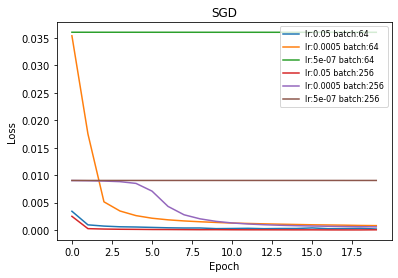

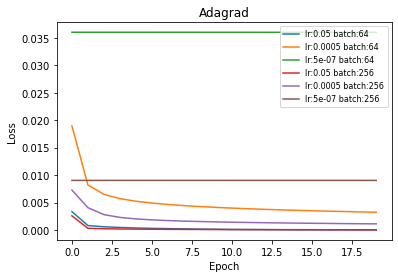

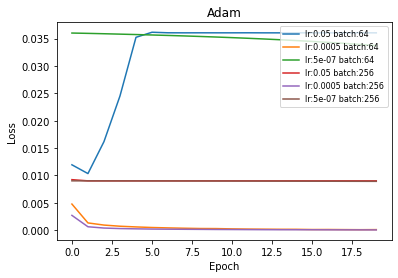

In [19]:
for opt in optim_list:
    plt.figure()
  for item in loss_hist.keys():
    if(item[-1] == opt):
      plt.plot(loss_hist[item], label="lr:{lr} batch:{bsz}".format(lr=item[0], bsz=item[1])) 
      plt.title("{opt}".format(opt=item[-1]))
      plt.legend(loc="upper right", prop={'size': 8})
      plt.xlabel("Epoch")
      plt.ylabel("Loss")


# for item in test_hist:
#   plt.figure()
#   plt.plot(test_hist[item], label="lr:{lr} batch:{bsz}".format(lr=item[0], bsz=item[1])) 
#   plt.plot(test_hist[item], label="lr:{lr} batch:{bsz}".format(lr=item[0], bsz=item[1])) 
#   plt.legend(loc="lower right")
#   plt.title("Accuracy (lr {:.7f}, batchsize {:3d})".format(lr, bsz))
#   plt.xlabel("Epoch")
#   plt.ylabel("Accuracy")